In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler



pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Preprocess Main Dataset

In [36]:
df = pd.read_csv(r"CDP\MergedFiltered.csv")

In [37]:
# Convert event_time to datetime
df["event_time"] = pd.to_datetime(df["event_time"])

# Format to YYYY-MM-DD 
df["event_time"] = df["event_time"].dt.strftime("%Y-%m-%d")

In [38]:
df = df.dropna(subset=["category_code"]) # dont want empty categories

In [39]:
df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68


In [40]:
df["subcategory"] = df["category_code"].str.split(".", n=1).str[1]
df["category"] = df["category_code"].str.split(".", n=1).str[0]

df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,subcategory,category
0,2019-10-01,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,smartphone,electronics
1,2019-10-01,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,smartphone,electronics


## RFM-T

In [ ]:
new_df = pd.DataFrame(columns=['user_id'])

In [ ]:
new_df['user_id'] = sorted(df['user_id'].unique())

new_df.head(2)

In [ ]:
# Recency

current_date = pd.to_datetime("2020-05-01")

# get date of purchase order
new_df['latest_date'] = pd.to_datetime(df.groupby('user_id', sort=True)['event_time'].max().values)

# count days between recent purchase and current date
new_df["recency"] = (current_date - new_df['latest_date']).dt.days

new_df.head(2)

,user_id,latest_date,recency
0,96369466,2020-04-19,12
1,101875240,2020-01-16,106


In [ ]:
# Frequency

# frequency = average number of transactions made per month

counts = (df.groupby("user_id", as_index=False)["user_session"].nunique().rename(columns={"user_session": "frequency"}))

# divide by 7.0 to get frequency per month (7 months)
counts["frequency"] = counts["frequency"] / 7.0

# merge back
new_df = new_df.merge(counts, on="user_id", how="left")

new_df.head(2)

,user_id,latest_date,recency,frequency_x,frequency_y
0,96369466,2020-04-19,12,0.142857,0.142857
1,101875240,2020-01-16,106,0.142857,0.142857


In [ ]:
new_df["monetary_value"] = df.groupby('user_id', sort=True)['price'].sum().values
new_df.head(2)

,user_id,latest_date,recency,frequency_x,frequency_y,monetary_value
0,96369466,2020-04-19,12,0.142857,0.142857,50.71
1,101875240,2020-01-16,106,0.142857,0.142857,184.52


In [ ]:
# time

# sort the orders by user, then sort by day
temp_df = df.sort_values(["user_id", "event_time"]).copy()
temp_df["event_time"] = pd.to_datetime(temp_df["event_time"], errors="coerce")

# calculate time between each order from each order in days
# for the single order, mark as 0 
temp_df["time"] = temp_df.groupby("user_id")["event_time"].diff().dt.days
temp_df["time"] = temp_df["time"].fillna(0)

# find the average among them per user
avg_time = temp_df.groupby("user_id", as_index=False)["time"].mean()

new_df = new_df.merge(avg_time, on="user_id", how="left")

new_df.head(2)

,user_id,latest_date,recency,frequency,monetary_value,time
0,96369466,2020-04-19,12,0.142857,50.71,0.0
1,101875240,2020-01-16,106,0.142857,184.52,0.0


In [ ]:
new_df.to_csv("Capstone2_modified.csv", index=False)

## Preprocess

In [41]:
numeric=["recency", "frequency", "monetary_value", "time"]

### One-Hot Encode

In [42]:
new_df = pd.read_csv("Capstone2_modified.csv")

new_df.head(2)

,user_id,latest_date,recency,frequency,monetary_value,time
0,96369466,2020-04-19,12,0.142857,50.71,0.0
1,101875240,2020-01-16,106,0.142857,184.52,0.0


In [43]:
ohe = OneHotEncoder(sparse_output=False)
one_hot_encoded = ohe.fit_transform(df[["category"]])

# Create DataFrame with user_id
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=ohe.get_feature_names_out(["category"]), 
                          index=df.index)

encoded_subset = pd.concat([df["user_id"], one_hot_df], axis=1)

# Aggregate per user (if a user belongs to multiple categories)
encoded_subset = encoded_subset.groupby("user_id", as_index=False).max()

# Merge into new_df
new_df = new_df.merge(encoded_subset, on="user_id", how="left")

# Check result
new_df.head(2)

,user_id,latest_date,recency,frequency,monetary_value,time,category_accessories,category_apparel,category_appliances,category_auto,category_computers,category_construction,category_country_yard,category_electronics,category_furniture,category_kids,category_medicine,category_sport,category_stationery
0,96369466,2020-04-19,12,0.142857,50.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,101875240,2020-01-16,106,0.142857,184.52,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
new_df.shape

(1888883, 19)

### Partition

In [45]:
portion = 0.15

holdout = new_df.groupby('frequency', group_keys=False).apply(lambda x : x.sample(frac=portion, random_state=1))
train = new_df.drop(holdout.index)

C:\Users\justi\AppData\Local\Temp\ipykernel_9336\2321590834.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  holdout = new_df.groupby('frequency', group_keys=False).apply(lambda x : x.sample(frac=portion, random_state=1))


### Transform

In [46]:
new_df2 = new_df.copy()
holdout2 = holdout.copy()
train2 = train.copy()
new_df3 = new_df.copy()
holdout3 = holdout.copy()
train3 = train.copy()

In [47]:
scaler = StandardScaler()

new_df[numeric] = scaler.fit_transform(new_df[numeric])

holdout[numeric] = scaler.transform(holdout[numeric])
train[numeric] = scaler.transform(train[numeric])

new_df.head(2)

,user_id,latest_date,recency,frequency,monetary_value,time,category_accessories,category_apparel,category_appliances,category_auto,category_computers,category_construction,category_country_yard,category_electronics,category_furniture,category_kids,category_medicine,category_sport,category_stationery
0,96369466,2020-04-19,-1.239664,-0.3048,-0.260845,-0.442916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,101875240,2020-01-16,0.309546,-0.3048,-0.225434,-0.442916,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
scaler = RobustScaler()

new_df2[numeric] = scaler.fit_transform(new_df2[numeric])

holdout2[numeric] = scaler.transform(holdout2[numeric])
train2[numeric] = scaler.transform(train2[numeric])

new_df2.head(2)

,user_id,latest_date,recency,frequency,monetary_value,time,category_accessories,category_apparel,category_appliances,category_auto,category_computers,category_construction,category_country_yard,category_electronics,category_furniture,category_kids,category_medicine,category_sport,category_stationery
0,96369466,2020-04-19,-0.647059,0.0,-0.395823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,101875240,2020-01-16,0.274510,0.0,-0.214690,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
scaler = StandardScaler(with_std=False)

new_df3[numeric] = scaler.fit_transform(new_df3[numeric])

holdout3[numeric] = scaler.transform(holdout3[numeric])
train3[numeric] = scaler.transform(train3[numeric])

new_df3.head(2)

,user_id,latest_date,recency,frequency,monetary_value,time,category_accessories,category_apparel,category_appliances,category_auto,category_computers,category_construction,category_country_yard,category_electronics,category_furniture,category_kids,category_medicine,category_sport,category_stationery
0,96369466,2020-04-19,-75.21796,-0.221927,-985.672006,-5.072486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,101875240,2020-01-16,18.78204,-0.221927,-851.862006,-5.072486,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

In [ ]:
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import gower
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree
from scipy.sparse import lil_matrix, save_npz
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import cupy as cp
import cudf
from cuml.manifold import UMAP

In [51]:
# Keep the IDs separate
ids = train['user_id']

# Use only the features for clustering
features = train.drop(columns=['user_id', 'latest_date'])
features2 = train2.drop(columns=['user_id', 'latest_date'])
features3 = train3.drop(columns=['user_id', 'latest_date'])
numeric=["recency", "frequency", "monetary_value", "time"]
categorical = [col for col in features.columns if col not in numeric]

samp = features.sample(n=100000, random_state=42)

In [ ]:
n_neighbors = 25
K = range(2, 10)


n_samples = samp.shape[0]
sparse_dist = lil_matrix((n_samples, n_samples)) # sparse matrix

tree = BallTree(samp, metric='euclidean') # ball tree object

distances, indices = tree.query(samp, k=n_neighbors)

for i in range(n_samples):
    for j in indices[i]:
        if i != j:
            # Compute Gower distance 
            d = gower.gower_matrix(samp.iloc[i:i+1], samp.iloc[j:j+1])[0][0]
            sparse_dist[i, j] = d
            sparse_dist[j, i] = d   

sparse_dist = sparse_dist.tocsr()
save_npz("gower_sparse_dist.npz", sparse_dist)

In [44]:
sparse_dist.shape

(100000, 100000)

## Modeling with Euclidean Distance

### K-Mean

c:\Users\justi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1 cluster(s) completed
2 cluster(s) completed
3 cluster(s) completed
4 cluster(s) completed
5 cluster(s) completed
6 cluster(s) completed
7 cluster(s) completed
8 cluster(s) completed
9 cluster(s) completed


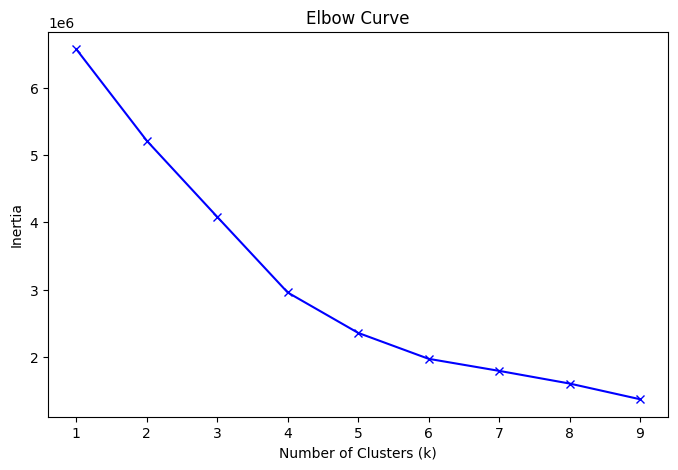

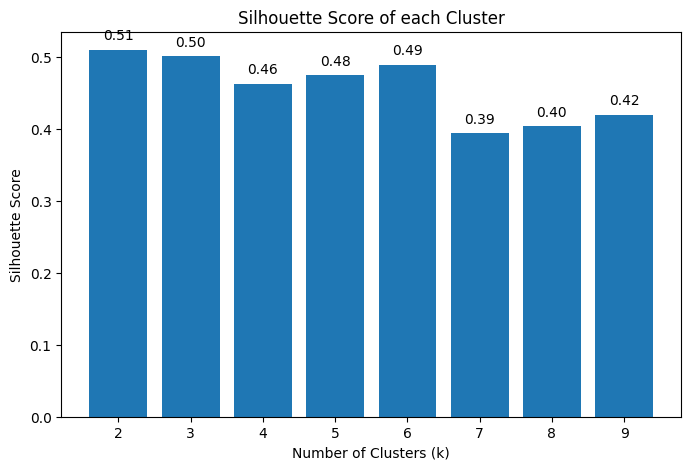

In [ ]:
inertias = []
sil_scores = []
K = range(1,10)


sample = features[numeric].sample(n=500000, random_state=1)

# Split that sample into disjoint partitions
n_partitions = 5
partitions = np.array_split(sample, n_partitions)

for k in K:
    kmean_ = KMeans(n_clusters=k, max_iter=200, random_state=1)
    kmean_.fit(features[numeric])

    inertias.append(kmean_.inertia_)

    if k != 1:
        scores = []
        for part in partitions:
            labels = kmean_.predict(part)
            score = silhouette_score(part, labels)
            scores.append(score)
        mean_score = np.mean(scores)
        sil_scores.append(mean_score)
        
    print(f"{k} cluster(s) completed")

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

plt.figure(figsize=(8, 5))
x = range(2, 10)
plt.bar(x, sil_scores)
for i, score in enumerate(sil_scores):
    plt.text(x[i], score + 0.01, f"{score:.2f}", ha='center', va='bottom')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Cluster (Standard Scaler)')
plt.show()

c:\Users\justi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1 cluster(s) completed
2 cluster(s) completed
3 cluster(s) completed
4 cluster(s) completed
5 cluster(s) completed
6 cluster(s) completed
7 cluster(s) completed
8 cluster(s) completed
9 cluster(s) completed


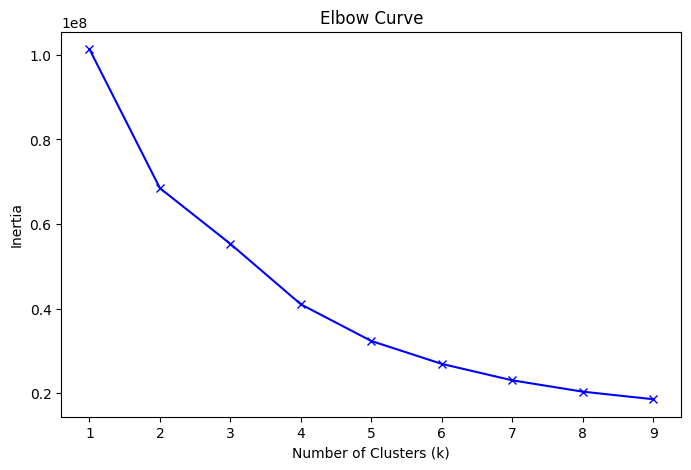

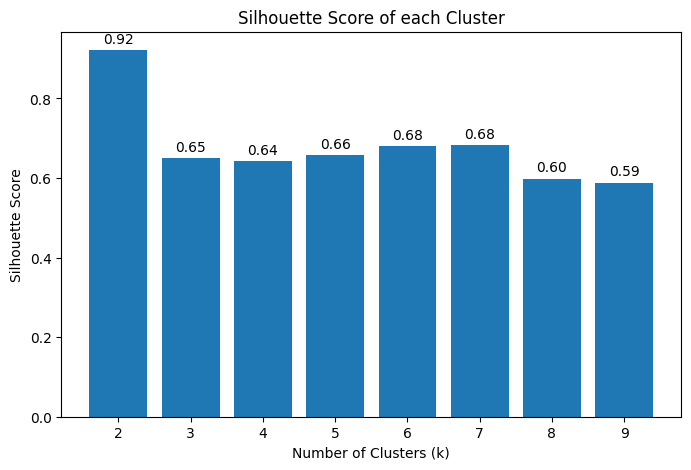

In [ ]:
inertias = []
sil_scores = []
K = range(1,10)

sample = features2[numeric].sample(n=500000, random_state=1)

# Split that sample into disjoint partitions
n_partitions = 5
partitions = np.array_split(sample, n_partitions)

for k in K:
    kmean_ = KMeans(n_clusters=k, max_iter=200, random_state=1)
    kmean_.fit(features2[numeric])

    inertias.append(kmean_.inertia_)

    if k != 1:
        scores = []
        for part in partitions:
            labels = kmean_.predict(part)
            score = silhouette_score(part, labels)
            scores.append(score)
        mean_score = np.mean(scores)
        sil_scores.append(mean_score)
    print(f"{k} cluster(s) completed")

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

plt.figure(figsize=(8, 5))
x = range(2, 10)
plt.bar(x, sil_scores)
for i, score in enumerate(sil_scores):
    plt.text(x[i], score + 0.01, f"{score:.2f}", ha='center', va='bottom')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Cluster (Robust Scaler)')
plt.show()

c:\Users\justi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1 cluster(s) completed
2 cluster(s) completed
3 cluster(s) completed
4 cluster(s) completed
5 cluster(s) completed
6 cluster(s) completed
7 cluster(s) completed
8 cluster(s) completed
9 cluster(s) completed


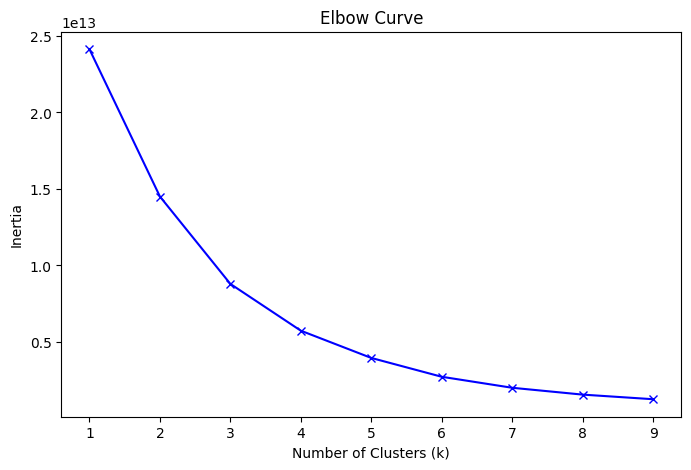

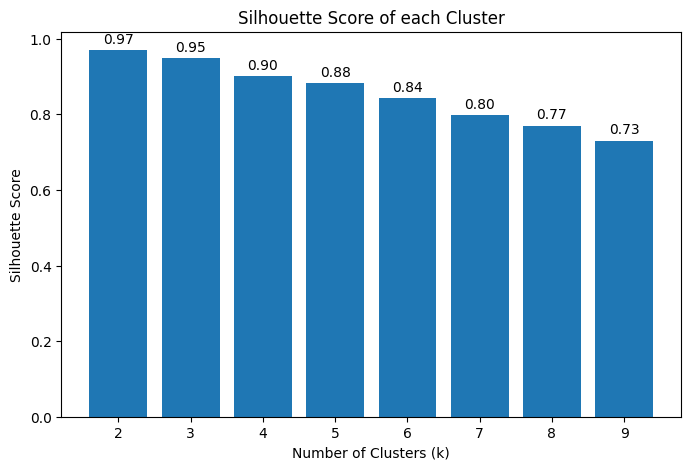

In [ ]:
inertias = []
sil_scores = []
K = range(1,15)


sample = features3[numeric].sample(n=50000, random_state=1)

# Split that sample into disjoint partitions
n_partitions = 5
partitions = np.array_split(sample, n_partitions)

for k in K:
    kmean_ = KMeans(n_clusters=k, max_iter=200, random_state=1)
    kmean_.fit(features3[numeric])

    inertias.append(kmean_.inertia_)

    if k != 1:
        scores = []
        for part in partitions:
            labels = kmean_.predict(part)
            score = silhouette_score(part, labels)
            scores.append(score)
        mean_score = np.mean(scores)
        sil_scores.append(mean_score)

    print(f"{k} cluster(s) completed")

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

plt.figure(figsize=(8, 5))
x = range(2, 10)
plt.bar(x, sil_scores)
for i, score in enumerate(sil_scores):
    plt.text(x[i], score + 0.01, f"{score:.2f}", ha='center', va='bottom')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Cluster (No Std Scaling)')
plt.show()

### Visualizing the clusters

In [76]:
def plot_radar_chart_kmeans_scaled(cluster_centers_scaled, fn, title):
    N = len(fn)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    
    ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')

    color_palette = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange
        '#2ca02c',  # green
        '#d62728',  # red
        '#9467bd',  # purple
        '#8c564b'   # brown
    ]
    
    for idx, centroid in enumerate(cluster_centers_scaled):
        values = centroid.flatten().tolist()
        values = values + [values[0]]  # close loop
        ax.plot(theta, values, linewidth=1.75, linestyle='solid', 
                label=f'Cluster {idx}', marker='o', markersize=10, color=color_palette[idx % len(color_palette)])
        ax.fill(theta, values, alpha=0.50, color=color_palette[idx % len(color_palette)])

    plt.xticks(theta, fn + [fn[0]], color='black', size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    return fig

In [77]:
kmean_ = KMeans(n_clusters=5, max_iter=200, random_state=1)
kmean_.fit(features3[numeric])

cluster_sizes = np.bincount(kmean_.labels_)
print(cluster_sizes)

ch_score = calinski_harabasz_score(features3[numeric], kmean_.labels_)
print("Calinski-Harabasz Index:", ch_score)

db_score = davies_bouldin_score(features3[numeric], kmean_.labels_)
print("Davies-Bouldin Index:", db_score)

[1548687    4346     268   52252      17]
Calinski-Harabasz Index: 2045984.3081260615
Davies-Bouldin Index: 0.47019962292998035


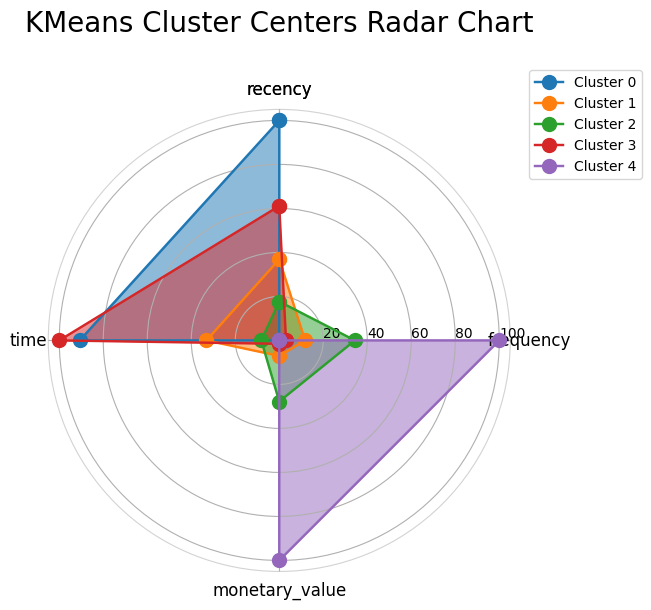

In [78]:
from sklearn.preprocessing import MinMaxScaler

# Scale cluster centers to 0-100
scaler = MinMaxScaler(feature_range=(0, 100))
centers_scaled = scaler.fit_transform(kmean_.cluster_centers_)

fig = plot_radar_chart_kmeans_scaled(centers_scaled, numeric, title="KMeans Cluster Centers Radar Chart")
plt.show()


In [ ]:
mapper = umap.UMAP(n_components=2).fit(features3[numeric])
umap.plot.points(mapper, labels=kmean_.labels_, color_key_cmap='Spectral')

In [79]:
kmean_ = KMeans(n_clusters=6, max_iter=200, random_state=1)
kmean_.fit(features3[numeric])

ch_score = calinski_harabasz_score(features3[numeric], kmean_.labels_)
print("Calinski-Harabasz Index:", ch_score)

db_score = davies_bouldin_score(features3[numeric], kmean_.labels_)
print("Davies-Bouldin Index:", db_score)

cluster_sizes = np.bincount(kmean_.labels_)
print(cluster_sizes)

Calinski-Harabasz Index: 2520134.453929098
Davies-Bouldin Index: 0.46868465101159856
[1508959    1381     143   84587      15   10485]


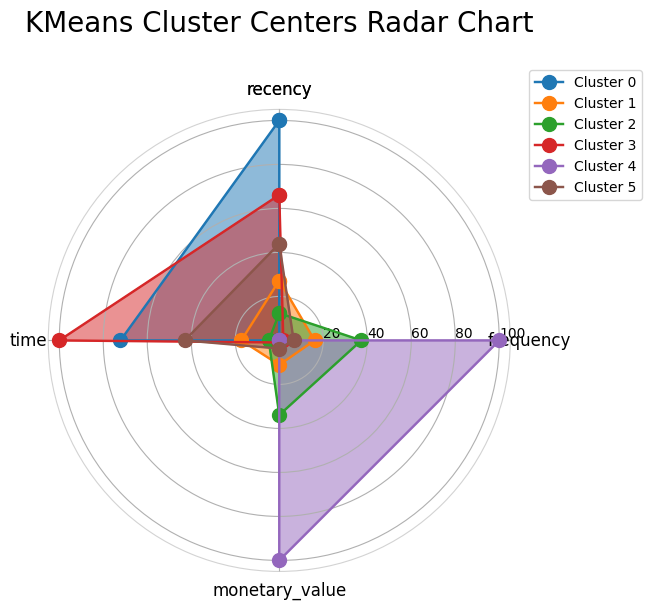

In [80]:
scaler = MinMaxScaler(feature_range=(0, 100))
centers_scaled = scaler.fit_transform(kmean_.cluster_centers_)

fig = plot_radar_chart_kmeans_scaled(centers_scaled, numeric, title="KMeans Cluster Centers Radar Chart")
plt.show()

In [ ]:
kmean_ = KMeans(n_clusters=4, max_iter=200, random_state=1)
kmean_.fit(features3[numeric])

cluster_sizes = np.bincount(kmean_.labels_)
print(cluster_sizes)

ch_score = calinski_harabasz_score(features3[numeric], kmean_.labels_)
print("Calinski-Harabasz Index:", ch_score)

db_score = davies_bouldin_score(features3[numeric], kmean_.labels_)
print("Davies-Bouldin Index:", db_score)

[1563980    2467      96   39027]
Calinski-Harabasz Index: 1715434.401843184
Davies-Bouldin Index: 0.4973382555569188


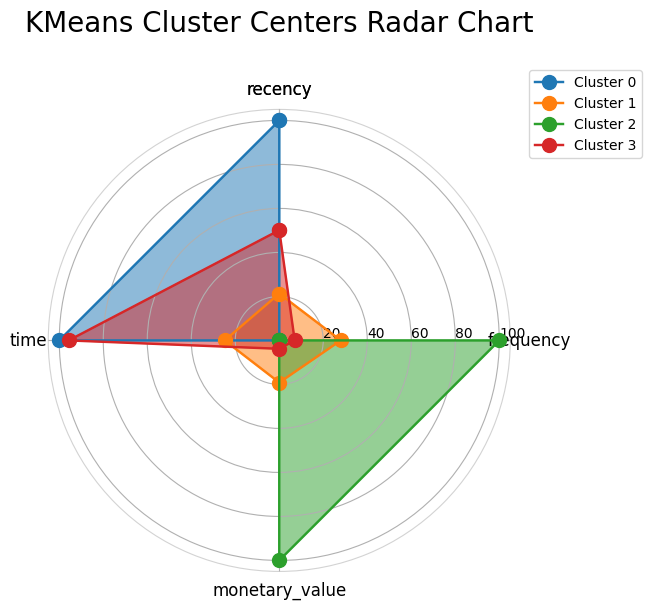

In [82]:
scaler = MinMaxScaler(feature_range=(0, 100))
centers_scaled = scaler.fit_transform(kmean_.cluster_centers_)

fig = plot_radar_chart_kmeans_scaled(centers_scaled, numeric, title="KMeans Cluster Centers Radar Chart")
plt.show()

In [90]:
kmean_ = KMeans(n_clusters=4, max_iter=200, random_state=1)
kmean_.fit(features2[numeric])

ch_score = calinski_harabasz_score(features2[numeric], kmean_.labels_)
print("Calinski-Harabasz Index:", ch_score)

db_score = davies_bouldin_score(features2[numeric], kmean_.labels_)
print("Davies-Bouldin Index:", db_score)

cluster_sizes = np.bincount(kmean_.labels_)
print(cluster_sizes)

Calinski-Harabasz Index: 786568.260413389
Davies-Bouldin Index: 0.8545761222577276
[ 310633   12541 1282177     219]


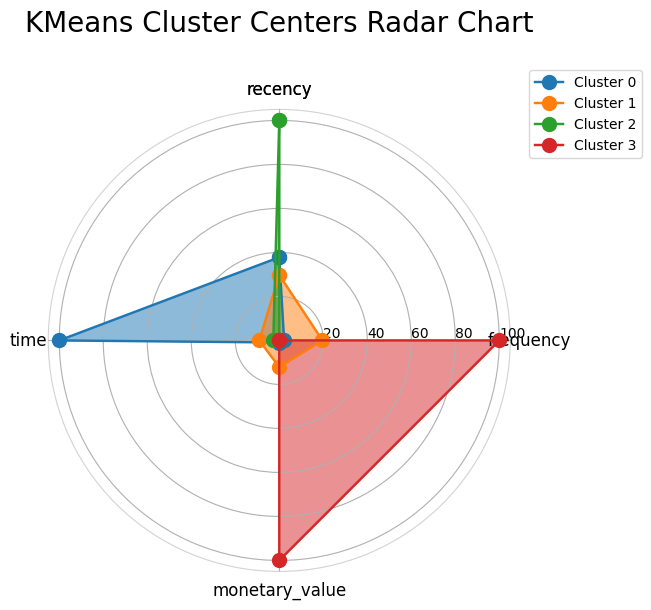

In [91]:
scaler = MinMaxScaler(feature_range=(0, 100))
centers_scaled = scaler.fit_transform(kmean_.cluster_centers_)

fig = plot_radar_chart_kmeans_scaled(centers_scaled, numeric, title="KMeans Cluster Centers Radar Chart")
plt.show()

In [ ]:
kmean_ = KMeans(n_clusters=5, max_iter=200, random_state=1)
kmean_.fit(features2[numeric])

ch_score = calinski_harabasz_score(features2[numeric], kmean_.labels_)
print("Calinski-Harabasz Index:", ch_score)

db_score = davies_bouldin_score(features2[numeric], kmean_.labels_)
print("Davies-Bouldin Index:", db_score)

cluster_sizes = np.bincount(kmean_.labels_)
print(cluster_sizes)

Calinski-Harabasz Index: 904286.2273589793
Davies-Bouldin Index: 1.4401910137577838
[ 201875   61090 1337895     151    4559]


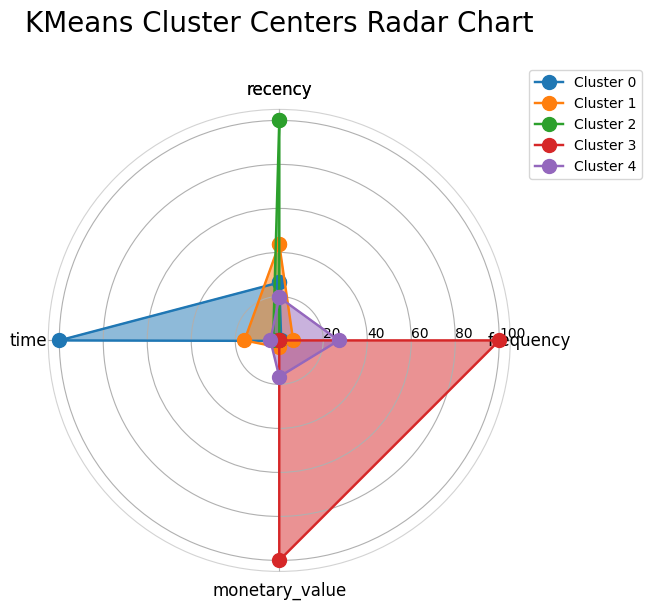

In [89]:
scaler = MinMaxScaler(feature_range=(0, 100))
centers_scaled = scaler.fit_transform(kmean_.cluster_centers_)

fig = plot_radar_chart_kmeans_scaled(centers_scaled, numeric, title="KMeans Cluster Centers Radar Chart")
plt.show()

In [ ]:
kmean_ = KMeans(n_clusters=6, max_iter=200, random_state=1)
kmean_.fit(features2[numeric])

ch_score = calinski_harabasz_score(features2[numeric], kmean_.labels_)
print("Calinski-Harabasz Index:", ch_score)

db_score = davies_bouldin_score(features2[numeric], kmean_.labels_)
print("Davies-Bouldin Index:", db_score)

cluster_sizes = np.bincount(kmean_.labels_)
print(cluster_sizes)

Calinski-Harabasz Index: 969519.584454825
Davies-Bouldin Index: 1.4273173888311215
[ 170018  106180 1315432      75   12498    1367]


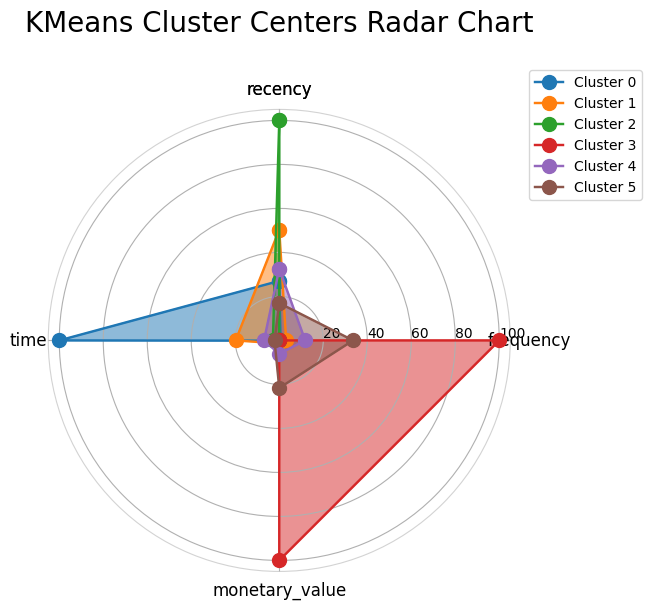

In [85]:
scaler = MinMaxScaler(feature_range=(0, 100))
centers_scaled = scaler.fit_transform(kmean_.cluster_centers_)

fig = plot_radar_chart_kmeans_scaled(centers_scaled, numeric, title="KMeans Cluster Centers Radar Chart")
plt.show()

### HDBSCAN

In [ ]:
from hdbscan import HDBSCAN
from hdbscan.validity import validity_index
from hdbscan import approximate_predict

sil_scores = []
validity_scores = []
min_sizes = [100, 500, 1000, 1200]
n_partitions = 32
features_subset = features[numeric].values
sil_sample_size = 5000

for size in min_sizes:
    print(f"Evaluating min_cluster_size={size}...")

    model = HDBSCAN(
        metric='euclidean',
        min_cluster_size=size,
        min_samples=10
    )

    model.fit(X_sample)
    labels = model.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    s_score, v_score = np.nan, np.nan

    if n_clusters > 1:
        try:
            v_score = validity_index(X_sample, labels, metric='euclidean')
        except Exception as e:
            print(f"Validity index failed (partition {i+1}): {e}")

    validity_scores.append((size, i, v_score))

val_df = pd.DataFrame(validity_scores, columns=["min_cluster_size", "partition", "validity"])


val_mean = val_df.groupby("min_cluster_size")["validity"].mean().values

# Ensure same x order
min_sizes_sorted = sorted(val_df["min_cluster_size"].unique())

# --- Plot bar chart ---
x = np.arange(len(min_sizes_sorted))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x + width/2, val_mean, width, label='Validity Index', color='lightcoral')

# Annotate bars
for i, v in enumerate(val_mean):
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, min_sizes_sorted)
plt.xlabel("Min Cluster Size")
plt.ylabel("Score Value")
plt.title("HDBSCAN Cluster Evaluation: Silhouette vs Validity Index")
plt.legend()
plt.tight_layout()
plt.show()

Evaluating min_cluster_size=100...
Evaluating min_cluster_size=500...
Evaluating min_cluster_size=1000...
Evaluating min_cluster_size=1200...


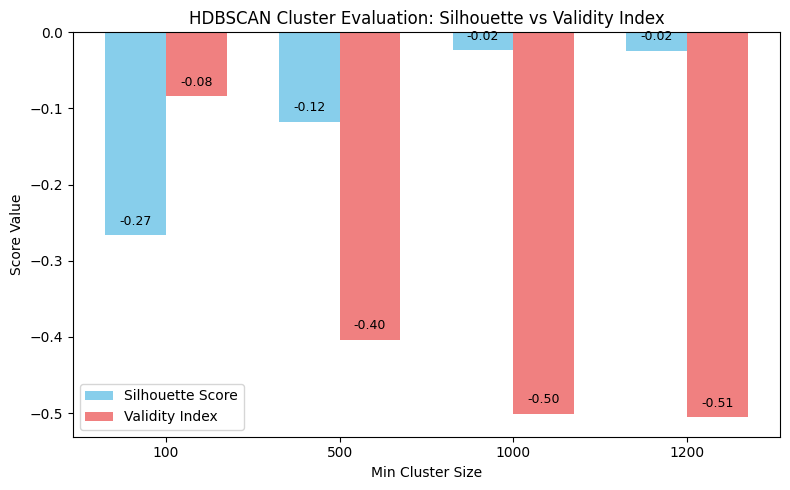

In [18]:
from hdbscan import HDBSCAN
from hdbscan.validity import validity_index
from hdbscan import approximate_predict

sil_scores = []
validity_scores = []
min_sizes = [100, 500, 1000, 1200]
n_partitions = 32
features_subset = features[numeric].values
sil_sample_size = 5000

for size in min_sizes:
    print(f"Evaluating min_cluster_size={size}...")
    n = len(features_subset)
    partition_size = n // n_partitions

    for i in range(n_partitions):
        # sample indices for this partition with replacement
        idx = np.random.choice(n, partition_size, replace=True)
        X_sample = features_subset[idx]

        model = HDBSCAN(
            metric='euclidean',
            min_cluster_size=size,
            min_samples=10
        )

        model.fit(X_sample)
        labels = model.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        s_score, v_score = np.nan, np.nan

        if n_clusters > 1:
            try:
                if len(X_sample) > sil_sample_size:
                    sub_idx = np.random.choice(len(X_sample), sil_sample_size, replace=False)
                    s_score = silhouette_score(X_sample[sub_idx], labels[sub_idx], metric='euclidean')
                else:
                    s_score = silhouette_score(X_sample, labels, metric='euclidean')
            except Exception as e:
                print(f"Silhouette score failed (partition {i+1}): {e}")

            try:
                v_score = validity_index(X_sample, labels, metric='euclidean')
            except Exception as e:
                print(f"Validity index failed (partition {i+1}): {e}")

        sil_scores.append((size, i, s_score))
        validity_scores.append((size, i, v_score))

sil_df = pd.DataFrame(sil_scores, columns=["min_cluster_size", "partition", "silhouette"])
val_df = pd.DataFrame(validity_scores, columns=["min_cluster_size", "partition", "validity"])

# --- Aggregate (mean over partitions) ---
sil_mean = sil_df.groupby("min_cluster_size")["silhouette"].mean().values
val_mean = val_df.groupby("min_cluster_size")["validity"].mean().values

# Ensure same x order
min_sizes_sorted = sorted(sil_df["min_cluster_size"].unique())

# --- Plot bar chart ---
x = np.arange(len(min_sizes_sorted))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, sil_mean, width, label='Silhouette Score', color='skyblue')
plt.bar(x + width/2, val_mean, width, label='Validity Index', color='lightcoral')

# Annotate bars
for i, (s, v) in enumerate(zip(sil_mean, val_mean)):
    plt.text(x[i] - width/2, s + 0.01, f"{s:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, min_sizes_sorted)
plt.xlabel("Min Cluster Size")
plt.ylabel("Score Value")
plt.title("HDBSCAN Cluster Evaluation: Silhouette vs Validity Index")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import hdbscan
from hdbscan.validity import validity_index
from hdbscan import approximate_predict

sil_scores = []
validity_scores = []
min_sizes = [100, 500, 1000, 2000]

for size in min_sizes:

    model = hdbscan.HDBSCAN(
        metric='euclidean',
        min_cluster_size=size,
        min_samples=10,
        n_jobs=10
    )

    model.fit(features2[numeric])
    labels = model.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    s_score, v_score = np.nan, np.nan

    if n_clusters > 1:
        try:
            # Silhouette score (higher = better)
            s_score = silhouette_score(features2[numeric], labels, metric='euclidean')
        except Exception as e:
            print(f"Silhouette score failed: {e}")

        try:
            # HDBSCAN validity index (higher = better)
            v_score = validity_index(
                features2[numeric],
                labels,
                metric='euclidean'
            )
        except Exception as e:
            print(f"Validity index failed: {e}")

    sil_scores.append(s_score)
    validity_scores.append(v_score)

x = np.arange(len(min_sizes))  # X positions
width = 0.35  # Bar width

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, sil_scores, width, label='Silhouette Score', color='skyblue')
plt.bar(x + width/2, validity_scores, width, label='Validity Index', color='lightcoral')

# Annotate bars
for i, (s, v) in enumerate(zip(sil_scores, validity_scores)):
    plt.text(x[i] - width/2, s + 0.01, f"{s:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, min_sizes)
plt.xlabel("Min Cluster Size")
plt.ylabel("Score Value")
plt.title("HDBSCAN (Robust Scaler)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sil_scores = []
validity_scores = []
min_sizes = [100, 500, 1000, 2000]

for size in min_sizes:

    model = hdbscan.HDBSCAN(
        metric='euclidean',
        min_cluster_size=size,
        min_samples=10,
        n_jobs=10
    )

    model.fit(features3[numeric])
    labels = model.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    s_score, v_score = np.nan, np.nan

    if n_clusters > 1:
        try:
            # Silhouette score (higher = better)
            s_score = silhouette_score(features3[numeric], labels, metric='euclidean')
        except Exception as e:
            print(f"Silhouette score failed: {e}")

        try:
            # HDBSCAN validity index (higher = better)
            v_score = validity_index(
                features3[numeric],
                labels,
                metric='euclidean'
            )
        except Exception as e:
            print(f"Validity index failed: {e}")

    sil_scores.append(s_score)
    validity_scores.append(v_score)

x = np.arange(len(min_sizes))  # X positions
width = 0.35  # Bar width

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, sil_scores, width, label='Silhouette Score', color='skyblue')
plt.bar(x + width/2, validity_scores, width, label='Validity Index', color='lightcoral')

# Annotate bars
for i, (s, v) in enumerate(zip(sil_scores, validity_scores)):
    plt.text(x[i] - width/2, s + 0.01, f"{s:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, min_sizes)
plt.xlabel("Min Cluster Size")
plt.ylabel("Score Value")
plt.title("HDBSCAN (Robust Scaler)")
plt.legend()
plt.tight_layout()
plt.show()

### Hierarchal Clustering

## Modeling with Gower

### K-Medioids

In [ ]:
inertias = []
sil_scores = []

for k in K:
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', init='k-medoids++', random_state=1)
    kmedoids.fit(sparse_dist)

    inertias.append(kmedoids.inertia_)

    score = silhouette_score(sparse_dist, kmedoids.labels_, metric='precomputed')
    sil_scores.append(score)

    print(f"{k} cluster completed")

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

plt.figure(figsize=(8, 5))
x = range(2, 10)
plt.bar(x, sil_scores)
for i, score in enumerate(sil_scores):
    plt.text(x[i], score + 0.01, f"{score:.2f}", ha='center', va='bottom')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Cluster')
plt.show()


### HDBSCAN

In [ ]:
import hdbscan
from hdbscan.validity import validity_index
from hdbscan import approximate_predict

sil_scores = []
validity_scores = []
min_size = [100,500,1000,2000]

sparse_dist = load_npz("gower_sparse_dist.npz")
dense_dist = sparse_dist.toarray()

for size in min_size:
    model = hdbscan.HDBSCAN(
        metric='precomputed',
        min_cluster_size=100,
        min_samples=10,
        approx_min_span_tree=True
    )
    model.fit(sparse_dist)

    labels = model.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    v_score, s_score = np.nan, np.nan

    if n_clusters > 1:  
        try:
            s_score = silhouette_score(samp, labels, metric='euclidean')
        except Exception as e:
            print(f"Silhouette score failed: {e}")


    validity_scores.append(v_score)
    sil_scores.append(s_score)

    print(f"{min_size} size completed")


x = np.arange(len(min_size))  # X positions
width = 0.35  # Bar width

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, sil_scores, width, label='Silhouette Score', color='skyblue')
plt.bar(x + width/2, validity_scores, width, label='Validity Index', color='lightcoral')

# Annotate bars
for i, (s, v) in enumerate(zip(sil_scores, validity_scores)):
    plt.text(x[i] - width/2, s + 0.01, f"{s:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, min_size)
plt.xlabel("Min Cluster Size")
plt.ylabel("Score Value")
plt.title("HDBSCAN Cluster Evaluation: Silhouette vs Validity Index")
plt.legend()
plt.tight_layout()
plt.show()

56 connected components found

Running HDBSCAN for min_cluster_size = 100...


ValueError: There exists points with less than 10 neighbors. Ensure your distance matrix has non zeros values for at least `min_sample`=10 neighbors for each points (i.e. K-nn graph), or specify a `max_dist` to use when distances are missing.

In [58]:
print(sil_scores)

[nan, nan, nan, nan]


In [ ]:
HDBSCAN_ = hdbscan.HDBSCAN(min_cluster_size=size , min_samples=50, metric="precomputed")

### Hierarchal Clustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(metric='precomputed', linkage='average',compute_distances=True).fit(sparse_dist)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=6)
plt.show()

In [ ]:
clusters = AgglomerativeClustering(metric='precomputed', linkage='average').fit(distances)